<center><img src='https://raw.githubusercontent.com/Jangrae/img/master/ml_python.png' width=600/></center>

# 다룰 내용

- 하이퍼파라미터 값을 어떻게 설정할 때 최고 성능이 나올 것으로 기대할 수 있을까요?

In [12]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format='retina'

## 1.데이터 준비

In [13]:
# 데이터 읽어오기
path = 'https://raw.githubusercontent.com/jangrae/csv/master/admission_simple.csv'
data = pd.read_csv(path)

# 확인
data.head()

,GRE,TOEFL,RANK,SOP,LOR,GPA,RESEARCH,ADMIT
0,337,118,4,4.5,4.5,9.65,1,1
1,324,107,4,4.0,4.5,8.87,1,1
2,316,104,3,3.0,3.5,8.00,1,0
3,322,110,3,3.5,2.5,8.67,1,1
4,314,103,2,2.0,3.0,8.21,0,0


In [14]:
# 라이브러리 불러오기
from sklearn.model_selection import train_test_split

# Target 확인
target = 'ADMIT'

# 데이터 분리
x = data.drop(target, axis=1)
y = data.loc[:, target]

# 학습용, 평가용 데이터 7:3으로 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

## 2.성능 검증
- 다음과 같이 K-Fold CV를 사용해 모델 성능을 평가합니다.

In [15]:
# 불러오기
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# 선언하기
model = DecisionTreeClassifier(random_state=1)

# 성능검증
cv_score = cross_val_score(model, x_train, y_train, cv=10)

# 확인
print('성능:', cv_score.round(2))
print('평균:', cv_score.mean().round(2))

성능: [0.89 0.83 0.74 0.89 0.86 0.86 0.71 0.66 0.71 0.74]
평균: 0.79


- 정확도가 79% 정도가 될 것으로 검증되었습니다.
- 하지만 Decision Tree의 하이퍼파라미터(max_depth 등) 설정에 따라 성능이 달라질 것입니다.
- 적절한 하이퍼파라미터 값을 알아야 제대로된 성능 검증이 가능할 것입니다.

## 3.이 방법은 어떨지...

- 반복문을 사용해 max_depth 값을 바꿔가면서 K-Fold CV로 성능을 검증해 보면 어떨까요?

In [16]:
# max_depth:1 ~ 10
result = []
for n in range(1, 11):
    model = DecisionTreeClassifier(max_depth=n, random_state=1)
    cv_score = cross_val_score(model, x_train, y_train, cv=5)
    result.append(cv_score.mean())

# 확인
result = np.array(result)
print('성능정보:', result.round(2))
print('최고성능:', result.max().round(2))
print('파라미터:', result.argmax() + 1)

성능정보: [0.87 0.86 0.85 0.83 0.81 0.83 0.83 0.81 0.83 0.81]
최고성능: 0.87
파라미터: 1


- K-Fold CV를 사용해 학습 데이터로 성능을 충분히 검증했습니다.
- 적절한 max_depth를 찾았기에 최선의 노력을 한 느낌입니다.

## 4.성능 확인


- 위에서 찾은 max_depth 값을 지정해 모델을 만들고 성능을 확인합니다.

In [17]:
# 불러오기
from sklearn.metrics import confusion_matrix, classification_report

# 선언하기
model = DecisionTreeClassifier(max_depth=1, random_state=1)

# 학습하기
model.fit(x_train, y_train)

# 예측하기
y_pred = model.predict(x_test)

# 평가하기
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[78  6]
 [12 54]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        84
           1       0.90      0.82      0.86        66

    accuracy                           0.88       150
   macro avg       0.88      0.87      0.88       150
weighted avg       0.88      0.88      0.88       150



- 실제 평가에서 예상했던 성능이 나오지 않을 가능성은 충분히 있습니다.
- 성능이 더 좋을 수도 있고 나쁠 수도 있습니다.
- 그런데, 모델을 새로 만들고 학습을 다시 한 후 성능을 평가하니 번거롭습니다.
- 최선의 하이퍼파라미터로 자동 학습되어 평가를 기다리면 참 좋을 텐데요.
- 이런 아쉬움을 남기고, 모델의 트리를 시각화해 확인하고 끝냅니다.

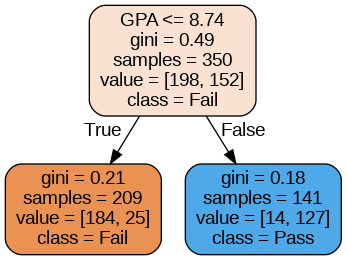

In [18]:
# 시각화 모듈 불러오기
from sklearn.tree import export_graphviz
from IPython.display import Image

# 이미지 파일 만들기
export_graphviz(model,                                 # 모델 이름
                out_file='tree.dot',                   # 파일 이름 
                feature_names=x.columns,               # Feature 이름
                class_names=['Fail', 'Pass'],          # Target Class 이름
                rounded=True,                          # 둥근 테두리
                precision=2,                           # 불순도 소숫점 자리수
                max_depth=3,                           # 표시할 깊이 지정
                filled=True)                           # 박스 내부 채우기

# 파일 변환(dpi defaulr 96)
!dot tree.dot -Tpng -otree.png -Gdpi=96   

# 이미지 파일 표시
Image(filename='tree.png', width=650)